# Main run script

This script contains the main procedure to calculate global root zone storage capacities. 

This scripts only works in the conda environment **sr_env**. In this environment all required packages are available. If you have **not** installed and activated this environment before opening this script, you should check the installation section in the *README* file. 
 

### 1. Getting started
First, import all the required packages.

In [1]:
# import packages
import glob
from pathlib import Path
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt

from scipy.optimize import least_squares
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

Here we import all the python functions defined in the scripts *f_catch_characteristics.py* and *f_preprocess_discharge.py*.

In [2]:
# import python functions
from f_catch_characteristics import *
from f_preprocess_discharge import *
from f_sr_calculation import *
from f_regression import *

### 2. Define working and data directories
Here we define the working directory, where all the scripts and output are saved.

We also define the data directory where you have the following subdirectories:

/data/forcing/*netcdf forcing files*\
/data/shapes/*catchment shapefiles*\
/data/gsim_discharge/*gsim discharge timeseries*


In [4]:
# Check current working directory (helpful when filling in work_dir below)
os.getcwd()

'/work/users/vanoorschot/fransje/scripts/GLOBAL_SR/global_sr_module/scripts'

In [5]:
# define your script working directory
# work_dir=Path("/home/fransjevanoors/global_sr_module")
work_dir=Path("/work/users/vanoorschot/fransje/scripts/GLOBAL_SR/global_sr_module")
# define your data directory
data_dir=Path("/work/users/vanoorschot/fransje/scripts/GLOBAL_SR/global_sr_module/data")

Here we create the output directory inside your working directory. In the remainder of this module, the same command will be used regularly to create directories.

In [6]:
# make output directory
if not os.path.exists(f'{work_dir}/output'):
    os.makedirs(f'{work_dir}/output')

### 3. Make lists of catchment IDs
The module calculates catchment root zone storage capacities for a large sample of catchments. Here we save the catchment names in a .txt file, for later use in the scripts.

In [7]:
# list the filenames of catchment shapefiles
shape_dir = Path(f'{data_dir}/shapes/')
shapefiles = glob.glob(f"{shape_dir}/*shp")

# make an empty list
catch_id_list = []

# loop over the catchment shapefiles, extract the catchment id and store in the empty list
for i in shapefiles:
    catch_id_list.append(Path(i).name.split('.')[0])
    
# save the catchment id list in your output directory
np.savetxt(f'{work_dir}/output/catch_id_list.txt',catch_id_list,fmt='%s')

In [8]:
# print catch_id_list as check
print(catch_id_list)

['br_0000495', 'fr_0000326', 'us_0002247', 'br_0000208', 'ca_0002435', 'zw_0000005']


### 4. Preprocess GSIM discharge data

The GSIM yearly discharge timeseries are stored in *.year* files. A detailed explanation of the column names is provided in Table 3 and 4 in https://essd.copernicus.org/articles/10/787/2018/. Here we preprocess these data into readable *.csv* files for each catchment. The preprocessing function *preprocess_gsim_discharge* is defined in the file *f_preprocess_discharge.py*. With this function we generate for each catchment a file with the yearly discharge timeseries and a file with the specifications of the catchment.

In [9]:
# make output directories
if not os.path.exists(f'{work_dir}/output/discharge/timeseries'):
    os.makedirs(f'{work_dir}/output/discharge/timeseries')
    
if not os.path.exists(f'{work_dir}/output/discharge/characteristics'):
    os.makedirs(f'{work_dir}/output/discharge/characteristics')

In [10]:
# define folder with discharge timeseries data
fol_in = f'{data_dir}/gsim_discharge/'

# define output folder
fol_out = f'{work_dir}/output/discharge/'

# run preprocess_gsim_discharge function (defined in f_preprocess_discharge.py) for all catchments in catch_id_list
for catch_id in catch_id_list:
    preprocess_gsim_discharge(catch_id, fol_in, fol_out)

In [11]:
# print output discharge dataframe for catchment [0]
catch_id = catch_id_list[0]
c = pd.read_csv(f'{fol_out}/timeseries/{catch_id}.csv')
c.head()

,date,Q,sd_mmd,iqr_mmd,min_mmd,max_mmd,min7_mmd,max7_mmd,doymin,doymax,doy7min,doy7max,nr_mis_days,nr_av_days
0,1964-12-31,2.782319,0.226279,0.264220,2.510092,3.170642,2.547837,3.114024,356.0,334.0,361.0,340.0,333.0,33.0
1,1965-12-31,3.429440,1.101704,1.770275,1.587963,6.816881,1.587963,5.910983,356.0,121.0,362.0,126.0,0.0,365.0
2,1966-12-31,2.563471,0.907277,1.030459,1.500771,14.400000,1.587963,4.642726,17.0,159.0,1.0,165.0,0.0,365.0
3,1967-12-31,2.727136,0.985530,1.638165,1.004037,4.967339,1.004037,4.529489,281.0,151.0,300.0,151.0,0.0,365.0
4,1968-12-31,2.812898,0.556125,0.930055,1.664587,3.989725,1.721206,3.566972,22.0,175.0,26.0,176.0,0.0,366.0


### 5. From gridded data to catchment timeseries
For this step go to the notebook *run_script_grid_to_catchments*. This part is run in another notebook. The output data of this script can be found in *work_dir/output/forcing_timeseries*.

### 6. Google earth engine for catchment characteristics
For this step go to the notebook *run_script_earthengine*. This part is run in another notebook. The output data of this script can be found in *work_dir/output/earth_engine_timeseries*.

### 7. Catchment descriptor variables
For the global root zone storage capacity estimation, we need to calculate catchment descriptor variables. These descriptors can be climatological variables (e.g. mean precipitation (p_mean); seasonality of precipitation (si_p); timelag between maximum P and Ep (phi)) or landscape variables (e.g. mean treecover (tc); mean elevation (h_mean)). A detailed list of all the descriptors considered is provided here xxxxx.\
To calculate the catchment descriptor variables we use the *catch_characteristics* function from the *f_catch_characteristics.py* file. In this function you specify the variables of interest, the catchment ID and your in- and output folders. Then, based on all the timeseries you have generated in the preceding codes it will return a table with the catchment descriptor variables for all your catchments (that is saved as csv in your *work_dir/catchment_characteristics.csv*).

In [12]:
# define in and output folder
fol_in=f'{work_dir}/output/'
fol_out=f'{work_dir}/output/'

# define variables of interest
var=['p_mean','ep_mean','q_mean','t_mean','ai','si_p','si_ep','phi','tc','ntc','nonveg']

# run catch_characteristics (defined in f_catch_characteristics.py) for the catchments in your catch_id_list
catch_characteristics(var, catch_id_list, fol_in, fol_out)

,p_mean,ep_mean,q_mean,t_mean,ai,si_p,si_ep,phi,tc,ntc,nonveg
br_0000495,6.382521,3.555781,3.21034,27.298084,1.79497,0.582343,0.046911,5,40.389229,47.804183,11.806588
fr_0000326,3.732327,2.069126,1.701488,11.05771,1.803818,0.207184,0.362239,4,28.631765,56.481887,14.886349
us_0002247,4.075435,2.644089,3.9137,17.055993,1.541338,0.221313,0.35646,6,39.580416,49.29533,11.124253
br_0000208,6.010284,3.950886,2.09371,26.098434,1.52125,0.606406,0.119056,2,66.629625,19.717785,13.652589
ca_0002435,1.559526,1.336701,0.357725,1.751724,1.166697,0.584034,0.739594,0,16.071882,59.186729,24.741389
zw_0000005,1.928311,2.835067,0.022799,21.17139,0.680164,0.991475,0.206729,1,9.820495,73.149696,17.029809


In [14]:
# combine catchment geometries in single shapefile
shape_dir = f'{data_dir}/shapes/'
out_dir = f'{work_dir}/output'
geo_catchments(shape_dir,out_dir)

### 8. Calculate root zone storage capacity
Here we calculate the catchment root zone storage capacity (Sr) based on catchment water balances. First, catchment root zone storage deficits (Sd) are computed as the cumulative difference between P and Et (transpiration). The result of one catchment is visualised in a figure. Second, the Sr is then calculated based on an extreme value analysis of the storage deficits for different return periods. A detailed description of this method can be found here xxxxxx.

Here we use the *run_sd_calculation* and *run_sr_calculation* functions from the *f_sr_calculation* file. The Sd result of one catchment is visualised using *plot_sd*. The Sr results are merged using the *merge_sr* function and visualised using the *plot_sr* function. The output of both storage deficit and Sr calculations are saved in your *work_dir/output/sr_calculation*.


In [15]:
# make output directories
if not os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments'):
    os.makedirs(f'{work_dir}/output/sr_calculation/sd_catchments')
    
if not os.path.exists(f'{work_dir}/output/sr_calculation/sr_catchments'):
    os.makedirs(f'{work_dir}/output/sr_calculation/sr_catchments')

Calculate storage deficits using the *run_sd_calculation* function from *f_sr_calculation*

In [16]:
# define directories
pep_dir = f'{work_dir}/output/forcing_timeseries/processed/daily'
q_dir = f'{work_dir}/output/discharge/timeseries'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'

# run sd calculation for all catchments in catch_id_list
for catch_id in catch_id_list:
    run_sd_calculation(catch_id, pep_dir, q_dir, out_dir)
    
#comRuud: print to screen what is being created (for some reason I did not get an Sd for the US catchment, but no error!)
# Fransje: this is correct, incorrect water balance in us catchment -> no sd calculated. add flag or so in table??

/home/vanoorschot/miniconda3/envs/sr_env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/vanoorschot/miniconda3/envs/sr_env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


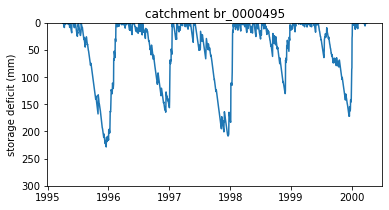

In [17]:
# plot sd example - use the first catchment from catch_id_list
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
plot_sd(catch_id_list[0], sd_dir)

Calculate Sr using the *run_sr_calculation* function from *f_sr_calculation* and merge the catchment Sr values into one dataframe with *merge_sr_catchments*. The functions return a table with the catchment Sr values for the different return periods.

In [18]:
# define directories
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
out_dir = f'{work_dir}/output/sr_calculation/sr_catchments'

# define return periods
rp_array = [2,3,5,10,20,30,40,50,60]

# run sr calculation for all catchments in catch_id_list
for catch_id in catch_id_list:
    run_sr_calculation(catch_id, rp_array, sd_dir, out_dir)
    
# merge catchment sr dataframes into one dataframe
sr_dir = f'{work_dir}/output/sr_calculation/sr_catchments'
out_dir = f'{work_dir}/output/sr_calculation/'
merge_sr_catchments(sr_dir,out_dir)

#comRuud: multiple Sr have been created (for different return periods? But values are the same, is that correct?) print to screen and tell what it should look like

,2,3,5,10,20,30,40,50,60
catch_id,,,,,,,,,
br_0000495,175.060098,189.415021,205.403310,225.493157,244.763820,255.849757,263.665685,269.707717,274.633997
fr_0000326,54.994168,58.702183,62.832113,68.021514,72.999313,75.862917,77.881847,79.442562,80.715068
ca_0002435,34.727881,38.557198,42.822231,48.181396,53.322035,56.279318,58.364294,59.976065,61.290199


Mapping Sr using the *plot_sr* function from *f_sr_calculation*

/work/users/vanoorschot/fransje/scripts/GLOBAL_SR/global_sr_module/scripts/f_sr_calculation.py:393: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh['centroid'] = sh.centroid


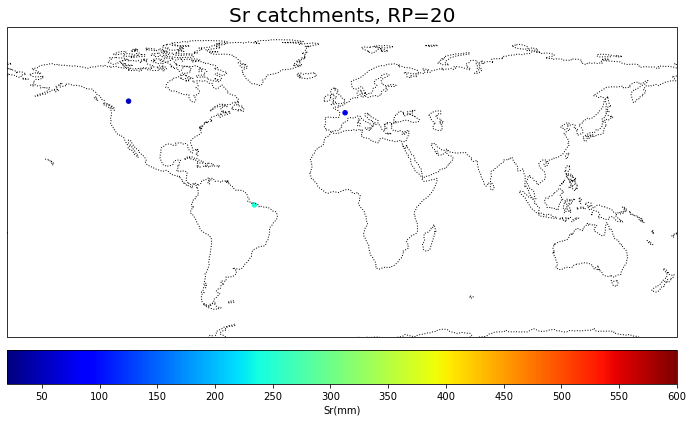

In [19]:
sr_file = f'{work_dir}/output/sr_calculation/sr_all_catchments.csv'
shp_file = f'{work_dir}/output/geo_catchments.shp'
rp=20
plot_sr(shp_file,sr_file,rp)

### 9. Regression

**move this to different script? to separate 'preprocessing' and 'analysis'?**

Here we run the linear regression model to predict the catchment Sr values based on the descriptor parameters. We use the *f_regression* function to calculate the linear regression parameters for the considered catchments.
We use the treecover data to separate the regression for high and low vegetation, the threshold values for tree cover (tc), non tree cover (ntc) and no-vegetation (nonveg) define this separation.

The output is a figure showing the estimated (step 8) and predicted (from regression) Sr values and a table with the regression parameter values, some statistics for the regression performance and the threshold values for tree cover. 

/work/users/vanoorschot/fransje/scripts/GLOBAL_SR/global_sr_module/scripts/f_regression.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_tc['ntc']>ntc_th]
/work/users/vanoorschot/fransje/scripts/GLOBAL_SR/global_sr_module/scripts/f_regression.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_tc['nonveg']>nonveg_th]


,p_mean,ep_mean,t_mean,si_p,tc_th,ntc_th,nonveg_th,r_sq,r_sq_adj,aic,pval,nobs
0,0.287,0.321,0.312,0.29,10,0,0,1.0,1.0,-204.221,NaN,3.0


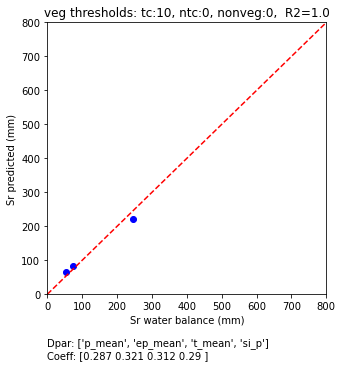

In [20]:
# read the catchment characteristics and sr tables
cc_df = pd.read_csv(f'{work_dir}/output/catchment_characteristics.csv',index_col=0)
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)

# define the descriptor variables
dpar = ['p_mean','ep_mean','t_mean','si_p']

# return period of Sr estimate
rp = 20

# define the vegetation thresholds for the regression
tc_th, ntc_th, nonveg_th = 10, 0, 0

# run the regression (r_regression in f_regression.py)
run_regression(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)